This is the text detection task implementation on MLT-2019 dataset. The image data can be downloaded from https://rrc.cvc.uab.es/?ch=15 after registration. This iPython notebook contains both of our methods in the report. By changing the initialization and input of the combined "MyModel" class, both the mobilenet+2d transformer and mobilenet+inception blocks method can be implemented.

In [ ]:
# check gpu status
!nvidia-smi

Thu Dec  9 18:54:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    93W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, LeakyReLU, Flatten, Dense
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt

Sample image visualization

(47, 387, 3)
3


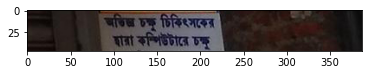

In [ ]:
im = Image.open('./gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/ImagesPart2/tr_img_08565.jpg')
k = np.asarray(im)
print(k.shape)
print(len(k.shape))
# im = tf.image.rgb_to_grayscale(np.asarray(im))
# h, w = im.shape[0], im.shape[1]
# print(im.shape)
plt.imshow(k[:,:,0:3], cmap='gray')

In [ ]:
img = Image.open('./gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/ImagesPart1/tr_img_00011.jpg')
img = tf.image.rgb_to_grayscale(np.asarray(img))
h, w = img.shape[0], img.shape[1]
print(img.shape)

(1300, 3638, 1)


In [ ]:
# image resizing
if max(h, w) <=1024:
  new_w = max(int((w//64)*64), 64)
  new_h = max(int((h//64)*64), 64)
elif h <= w:
  new_w = 1024
  new_h = max(int(((new_w*h/w)//64)*64), 64)
else:
  new_h = 1024
  new_w = max(int(((new_h*w/h)//64)*64), 64)
print(new_h, new_w)
h_blocks, w_blocks = int(new_h/64), int(new_w/64)
print(h_blocks, w_blocks)

320 1024
5 16


(1, 320, 1024, 1)


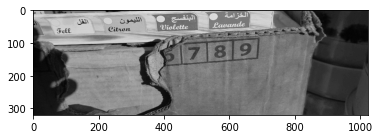

In [ ]:
xxx = tf.image.resize(tf.reshape(img, [1,h,w,1]), (new_h, new_w),
                      method = tf.image.ResizeMethod.BILINEAR)
print(xxx.shape)
plt.imshow(xxx[0,:,:,0], cmap='gray')

In [ ]:
x_np = xxx.numpy()/255
x_np.shape

(1, 320, 1024, 1)

In [ ]:
# convert to (64, 64, 1) patches
img_patches = tf.convert_to_tensor([[xxx[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blocks)] for i in range(h_blocks)])
img_patches.shape

TensorShape([5, 16, 64, 64, 1])

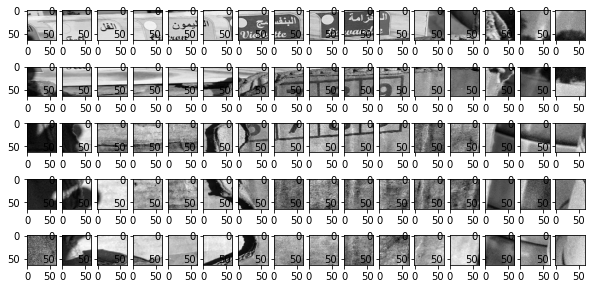

In [ ]:
# patches visualization
plt.figure(figsize = (10,5))
for i in range(h_blocks*w_blocks):
  plt.subplot(h_blocks, w_blocks, i+1)
  plt.imshow(img_patches[i//w_blocks][i%w_blocks][...,0], cmap='gray')

In [ ]:
# Load dataframe from csv ground truth labels
df = pd.read_csv('./gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/groundtruth_df.csv')
df = df[df['word'] != '###']

In [ ]:
df.size

983796

In [ ]:
# visualize sample ground truth
gt_np = np.asarray(df[df['image_id']==11])
gt_np

array([[11, 1370, 167, 1682, 169, 1695, 241, 1378, 255, 'Latin',
        'Violette'],
       [11, 252, 223, 413, 219, 413, 290, 252, 293, 'Latin', 'Fell'],
       [11, 1498, 64, 1759, 45, 1759, 143, 1501, 164, 'Arabic',
        'البنفسج'],
       [11, 941, 98, 1177, 76, 1188, 160, 938, 175, 'Arabic', 'الليمون'],
       [11, 481, 107, 589, 111, 617, 188, 478, 191, 'Arabic', 'الفل'],
       [11, 816, 205, 1066, 198, 1064, 265, 814, 272, 'Latin', 'Citron'],
       [11, 2083, 27, 2343, 23, 2336, 114, 2076, 118, 'Arabic',
        'الزخامة'],
       [11, 1948, 151, 2307, 135, 2308, 205, 1939, 227, 'Latin',
        'Lavande'],
       [11, 1407, 487, 1515, 484, 1545, 636, 1434, 644, 'Latin', '5'],
       [11, 1684, 463, 1818, 450, 1818, 620, 1682, 622, 'Latin', '7'],
       [11, 1965, 433, 2098, 426, 2096, 592, 1963, 599, 'Latin', '8'],
       [11, 2241, 405, 2378, 388, 2373, 559, 2236, 576, 'Latin', '9']],
      dtype=object)

In [ ]:
# x->width, y->height
# transform into blocks containing the image center
centers_x = ((gt_np[:,1]+gt_np[:,3]+gt_np[:,5]+gt_np[:,7])/4)/w * new_w //64
centers_y = ((gt_np[:,2]+gt_np[:,4]+gt_np[:,6]+gt_np[:,8])/4)/h * new_h //64
truth = np.concatenate([[centers_y], [centers_x]], axis=0)
truth, truth.shape

(array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0],
        [6.0, 1.0, 7.0, 4.0, 2.0, 4.0, 9.0, 9.0, 6.0, 7.0, 8.0, 10.0]],
       dtype=object), (2, 12))

In [ ]:
truth_locs = [[int(truth[0][i]), int(truth[1][i])] for i in range(truth.shape[1])]
truth_locs

[[0, 6],
 [0, 1],
 [0, 7],
 [0, 4],
 [0, 2],
 [0, 4],
 [0, 9],
 [0, 9],
 [2, 6],
 [2, 7],
 [1, 8],
 [1, 10]]

In [ ]:
# visualize the padded (16, 16) masks and labels
mask = np.zeros((16, 16))
binary_map = np.zeros((16, 16))
mask[0:h_blocks, 0:w_blocks] = 1
for i in range(len(truth_locs)):
  binary_map[truth_locs[i][0], truth_locs[i][1]] = 1
mask, binary_map

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
binary_map.reshape((256,))

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Create and store grayscaled images, truth binary maps and masks for all images

In [ ]:
parent_path = './gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/'

In [ ]:
# for i in range(10000):
#   print(f'saving img_{i} numpy files ...')

#   idx = str(i + 1).zfill(5)
#   if i < 5000:
#     name = f'{parent_path}/ImagesPart1/tr_img_{idx}'
#   else:
#     name = f'{parent_path}/ImagesPart2/tr_img_{idx}'

#   if os.path.isfile(f'{name}.jpg'):
#     path = f'{name}.jpg'
#   elif os.path.isfile(f'{name}.png'):
#     path = f'{name}.png'
#   else:
#     path = f'{name}.gif'

#   img = np.asarray(Image.open(path))
#   if len(img.shape) == 3:
#     img = tf.image.rgb_to_grayscale(img[:,:,0:3])
#   h, w = img.shape[0], img.shape[1]

#   if max(h, w) <=1024:
#     new_w = max(int((w//64)*64), 64)
#     new_h = max(int((h//64)*64), 64)
#   elif h <= w:
#     new_w = 1024
#     new_h = max(int(((new_w*h/w)//64)*64), 64)
#   else:
#     new_h = 1024
#     new_w = max(int(((new_h*w/h)//64)*64), 64)
#   h_blocks, w_blocks = int(new_h/64), int(new_w/64)

#   xxx = tf.image.resize(tf.reshape(img, [1,h,w,1]), (new_h, new_w),
#                         method = tf.image.ResizeMethod.BILINEAR)
#   xxx = xxx.numpy()/255
#   # img_patches = tf.convert_to_tensor([[xxx[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blocks)] for i in range(h_blocks)])
#   gt_np = np.asarray(df[df['image_id']==i+1])

#   # x->width, y->height
#   centers_x = ((gt_np[:,1]+gt_np[:,3]+gt_np[:,5]+gt_np[:,7])/4)/w * new_w //64
#   centers_y = ((gt_np[:,2]+gt_np[:,4]+gt_np[:,6]+gt_np[:,8])/4)/h * new_h //64
#   truth = np.concatenate([[centers_y], [centers_x]], axis=0)
#   truth_locs = [[int(truth[0][j]), int(truth[1][j])] for j in range(truth.shape[1])]

#   mask = np.zeros((16, 16))
#   binary_map = np.zeros((16, 16))
#   mask[0:h_blocks, 0:w_blocks] = 1
#   for j in range(len(truth_locs)):
#     binary_map[truth_locs[j][0], truth_locs[j][1]] = 1

#   mask_1d = mask.reshape((256,))
#   binary_map_1d = binary_map.reshape((256,))

#   save_path = f'{parent_path}/npy_files'
#   with open(f'{save_path}/img_npys/img_{i+1}.npy', 'wb') as f:
#     np.save(f, xxx)
#   with open(f'{save_path}/label_npys/label_{i+1}.npy', 'wb') as f:
#     np.save(f, binary_map_1d)
#   with open(f'{save_path}/mask_npys/mask_{i+1}.npy', 'wb') as f:
#     np.save(f, mask_1d)


In [ ]:
sizes = np.load(f'./gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/sizes.npy')

In [ ]:
num_blocks = []
for i in range(10000):
  h, w = sizes[i,1], sizes[i,0]
  if max(h, w) <=1024:
    new_w = max(int((w//64)*64), 64)
    new_h = max(int((h//64)*64), 64)
  elif h <= w:
    new_w = 1024
    new_h = max(int(((new_w*h/w)//64)*64), 64)
  else:
    new_h = 1024
    new_w = max(int(((new_h*w/h)//64)*64), 64)
  num_blocks.append([new_h//64, new_w//64])

In [ ]:
num_blocks = np.asarray(num_blocks)
num_blocks[0:10]

array([[ 9, 16],
       [ 9,  6],
       [ 6,  9],
       [ 6,  8],
       [16, 12],
       [ 6,  9],
       [ 9,  7],
       [ 4,  6],
       [ 5,  9],
       [16, 12]])

In [ ]:
min(num_blocks[:,0]*num_blocks[:,1]), max(num_blocks[:,0]*num_blocks[:,1])

(2, 256)

In [ ]:
# # create and store word center locations
# word_center_locs = []
# for i in range(10000):
#   print(f'saving img_{i} numpy files ...')
#   h, w = sizes[i,1], sizes[i,0]

#   if max(h, w) <=1024:
#     new_w = max(int((w//64)*64), 64)
#     new_h = max(int((h//64)*64), 64)
#   elif h <= w:
#     new_w = 1024
#     new_h = max(int(((new_w*h/w)//64)*64), 64)
#   else:
#     new_h = 1024
#     new_w = max(int(((new_h*w/h)//64)*64), 64)
#   h_blocks, w_blocks = int(new_h/64), int(new_w/64)

#   gt_np = np.asarray(df[df['image_id']==i+1])

#   # x->width, y->height
#   centers_x = ((gt_np[:,1]+gt_np[:,3]+gt_np[:,5]+gt_np[:,7])/4)/w * new_w //64
#   centers_y = ((gt_np[:,2]+gt_np[:,4]+gt_np[:,6]+gt_np[:,8])/4)/h * new_h //64
#   truth = np.concatenate([[centers_y], [centers_x]], axis=0)
#   truth_locs = [[int(truth[0][j]), int(truth[1][j])] for j in range(truth.shape[1])]
#   word_center_locs.append(truth_locs) 

In [ ]:
# word_center_locs[0:5]

In [ ]:
# with open(f"{parent_path}/npy_files/word_center_list", "wb") as fp:   # Pickling
#   pickle.dump(word_center_locs, fp)

In [ ]:
with open(f"{parent_path}/npy_files/word_center_list", "rb") as fp:   # Unpickling
  label_list = pickle.load(fp)

In [ ]:
label_list[0:5]

[[[8, 0],
  [6, 7],
  [4, 2],
  [4, 4],
  [3, 4],
  [4, 1],
  [3, 1],
  [2, 9],
  [5, 5],
  [8, 6],
  [7, 10],
  [7, 4],
  [7, 2],
  [1, 10],
  [2, 5],
  [8, 3],
  [8, 2],
  [8, 3],
  [3, 11],
  [3, 9],
  [3, 6],
  [8, 1]],
 [[6, 4], [6, 1], [7, 2], [7, 3], [7, 4]],
 [[2, 6], [2, 1], [2, 8], [1, 2], [2, 2], [2, 6], [3, 5]],
 [[2, 4], [2, 4], [2, 3], [2, 3], [2, 4], [2, 4]],
 [[3, 7], [3, 6]]]

Model Construction

In [ ]:
# Build customized mobileNet model
# MobileNet block
def mobilnet_block (x, filters, strides):
  x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)
    
  x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)
    
  return x

In [ ]:
#stem of the model
def mobile_net():
  input = Input(shape = (64, 64, 1))
  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)
  # main part of the model
  x = mobilnet_block(x, filters = 64, strides = 1)
  x = mobilnet_block(x, filters = 128, strides = 2)
  x = mobilnet_block(x, filters = 128, strides = 1)
  x = mobilnet_block(x, filters = 256, strides = 2)
  x = mobilnet_block(x, filters = 256, strides = 1)
  x = mobilnet_block(x, filters = 512, strides = 2)
  x = mobilnet_block(x, filters = 512, strides = 1)

  # for _ in range (5):
  #   x = mobilnet_block(x, filters = 512, strides = 1)
  x = mobilnet_block(x, filters = 512, strides = 1)
  x = mobilnet_block(x, filters = 512, strides = 1)

  x = mobilnet_block(x, filters = 1024, strides = 2)
  x = mobilnet_block(x, filters = 1024, strides = 1)
  x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Flatten()(x)
  mobile_out = keras.layers.Dense(512)(x)
  return keras.Model(inputs=input, outputs=mobile_out)

In [ ]:
mobile_net = mobile_net()
mobile_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 32, 32, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128   

This is the 2d-transformer encoder used in Method 1

In [ ]:
class Encoder(tf.keras.Model):

  def __init__(self, head_size: int, num_heads: int, ff_dim: int, stack=3, dropout=0):
    super(Encoder, self).__init__()
    self.head_size = head_size
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.stack = stack
    self.scale = tf.sqrt(float(head_size))
    self.pos_embeds = self._position_embedding()

    self.attention = [[layers.Attention(use_scale=False) for j in range(num_heads)] for i in range(stack)]
    self.attn_dense = [[[layers.Dense(head_size, use_bias=False) for k in range(2)] for j in range(num_heads)] for i in range(stack)]
    self.dropout = layers.Dropout(dropout)
    self.layer_norm = [[layers.LayerNormalization(epsilon=1e-6) for j in range(2)] for i in range(stack)]
    self.conv1 = [layers.Conv1D(filters=ff_dim, kernel_size=1) for i in range(stack)]
    self.leakyrelu = layers.LeakyReLU(alpha=0.1)
    self.conv2 = [layers.Conv1D(filters=head_size*num_heads, kernel_size=1) for i in range(stack)]

    self.avgpool = layers.GlobalAveragePooling1D()
    self.dense1 = layers.Dense(256)
    self.dropout2 = layers.Dropout(0.2)
    self.dense2 = layers.Dense(1)

  def get_angles(self, idx, d_model):
    angle_rates = 1 / np.power(10000, 4*idx/np.float32(d_model))
    return angle_rates

  # 2d positional embedding
  def _position_embedding(self, d_model=512):
    cube = np.zeros((16, 16, d_model))
    for x in range(16):
      for y in range(16):
        cube[x,y,0:256:2] = np.sin(x*self.get_angles(np.arange(0,128,1), d_model))
        cube[x,y,1:256:2] = np.cos(x*self.get_angles(np.arange(0,128,1), d_model))
        cube[x,y,256:512:2] = np.sin(y*self.get_angles(np.arange(0,128,1), d_model))
        cube[x,y,257:512:2] = np.cos(y*self.get_angles(np.arange(0,128,1), d_model))

    pos_enc = tf.cast(cube, dtype=tf.float32)
    return tf.reshape(tf.constant(pos_enc), [16*16, 512])

  def call(self, inputs, mask, training=False):
    # inputs shape: (batch_size, 16*16, 512)
    initials = inputs
    batch_size, seq_len, d_model = inputs.shape
    pos_embeds = tf.broadcast_to(self.pos_embeds, [batch_size, seq_len, d_model])
    pos_mask = tf.expand_dims(tf.constant(tf.cast(mask, dtype=tf.float32)), axis=-1)
    # print(pos_embeds.shape)
    # print(pos_embeds)
    inputs += pos_embeds * pos_mask

    for i in range(self.stack):
      # Attention
      x = inputs
      entries = [[self.attn_dense[i][j][0](x), self.attn_dense[i][j][1](x)] 
                 for j in range(self.num_heads)]
      attentions = [self.attention[i][j](inputs = [entries[j][0]/self.scale, entries[j][1], entries[j][1]],
                                         mask = [mask, mask])   
                    for j in range(self.num_heads)]
      x = tf.concat(attentions, axis=-1)
      # print(x.shape)
      # print(x)
      x = self.dropout(x, training=training)
      res = x + inputs

      # Feed Forward
      x = self.layer_norm[i][0](res)
      x = self.conv1[i](x)
      x = self.leakyrelu(x)
      x = self.dropout(x, training=training)
      x = self.conv2[i](x)
      inputs = self.layer_norm[i][1](x + res)

    # mask size is (batch_size, 16*16)
    # shape is (batch_size, 16*16, 512)

    x = tf.concat([inputs, initials], axis=-1)
    x = self.dropout2(x, training=training)
    x = self.dense1(x)
    x = self.leakyrelu(x)
    output = self.dense2(x)

    return output

In [ ]:
# pass sample inputs to build the model
encoder = Encoder(head_size=64, num_heads=8, ff_dim=512, stack=2, dropout=0)
a = np.random.normal(size=(2, 256, 512))
mk = np.zeros((2, 256), dtype=bool)
mk[0, 0:10] = 1
mk[1, 0:20] = 1
a = tf.convert_to_tensor(a)
mk = tf.convert_to_tensor(mk)

In [ ]:
out_enc = encoder(a, mk, training=False)
out_enc.shape

TensorShape([2, 256, 1])

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention (Attention)       multiple                  0         
                                                                 
 attention_1 (Attention)     multiple                  0         
                                                                 
 attention_2 (Attention)     multiple                  0         
                                                                 
 attention_3 (Attention)     multiple                  0         
                                                                 
 attention_4 (Attention)     multiple                  0         
                                                                 
 attention_5 (Attention)     multiple                  0         
                                                                 
 attention_6 (Attention)     multiple                  0   

This is the customized inception block used in Method 2

In [ ]:
def inception_blocks(stacks=2, embed_dim=512):
  inputs = Input(shape = (16, 16, embed_dim))
  x = inputs

  for i in range(stacks):
    conv_1 = layers.Conv2D(128, 1, padding="same")(x)
    conv_1 = BatchNormalization(epsilon=1e-6)(conv_1)
    conv_1 = LeakyReLU(alpha=0.1)(conv_1)

    conv_3 = layers.SeparableConv2D(128, 3, padding="same")(x)
    conv_3 = BatchNormalization(epsilon=1e-6)(conv_3)
    conv_3 = LeakyReLU(alpha=0.1)(conv_3)

    conv_5 = layers.SeparableConv2D(128, 5, padding="same")(x)
    conv_5 = BatchNormalization(epsilon=1e-6)(conv_5)
    conv_5 = LeakyReLU(alpha=0.1)(conv_5)

    conv_7 = layers.SeparableConv2D(128, 7, padding="same")(x)
    conv_7 = BatchNormalization(epsilon=1e-6)(conv_7)
    conv_7 = LeakyReLU(alpha=0.1)(conv_7)    
    # concatenate
    x = layers.Concatenate(axis=-1)([conv_1, conv_3, conv_5, conv_7])

  x = layers.Conv2D(512, 1, padding="same")(x)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)  

  outputs = layers.Concatenate(axis=-1)([x, inputs])
  outputs = layers.Reshape((256, -1))(outputs)

  outputs = layers.Dropout(0.2)(outputs)
  outputs = layers.Dense(256)(outputs)
  outputs = LeakyReLU(alpha=0.1)(outputs) 
  outputs = layers.Dense(1)(outputs)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
# Build model
inception = inception_blocks()
inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 512  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 128)  65664       ['input_2[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 16, 16, 128)  70272      ['input_2[0][0]']                
 v2D)                                                                                             
                                                                                            

Build the combined model. If we set cnn_blendering to False, then this corresponds to the first method with 2d transformer encoder; if set cnn_blendering to True, then this corresponds to the second method with customized inception blocks.

In [ ]:
class MyModel(tf.keras.Model):

  def __init__(self, mobile_net, encoder, cnn_blendering=False):
    super(MyModel, self).__init__()
    self.mobile_net = mobile_net
    self.encoder = encoder
    self.cnn_blendering = cnn_blendering

  def call(self, inputs, training=False): # inputs format sample: [(5, 16, 64, 64, 1), (16, 7, 64, 64, 1)]
    batch_size = len(inputs)
    batch_seq_len = [0]
    batch_inputs = []
    batch_h_shapes = []
    batch_w_shapes = []
    for j in range(batch_size):
      h_len = inputs[j].shape[0]
      w_len = inputs[j].shape[1]
      batch_h_shapes.append(h_len)
      batch_w_shapes.append(w_len)
      seq_len = h_len * w_len
      batch_seq_len.append(seq_len)
      for k in range(h_len):
        for l in range(w_len):
          batch_inputs.append(inputs[j][k,l,...])
    segments = [np.sum(batch_seq_len[0:i+1]) for i in range(batch_size+1)] # [0, 80, 192]

    train_batch = tf.convert_to_tensor(batch_inputs)
    mobile_out = self.mobile_net(train_batch, training=training)

    t_inputs = []
    attn_mask_2d = np.zeros((batch_size, 16, 16), dtype=bool)
    mask = []
    for j in range(batch_size):
      vecs = mobile_out[segments[j]:segments[j+1],:]
      assert(vecs.shape[0] == batch_h_shapes[j]*batch_w_shapes[j])
      vecs = tf.reshape(vecs, [batch_h_shapes[j], batch_w_shapes[j], 512])
      # print(vecs.shape) # (5, 16, 512)
      paddings = tf.constant([[0, 16-batch_h_shapes[j]], [0, 16-batch_w_shapes[j]], [0, 0]])
      # print(paddings.shape)
      vecs = tf.pad(vecs, paddings, "CONSTANT")  # (16, 16, 512)
      if self.cnn_blendering:
        t_inputs.append(vecs)
      else:
        t_inputs.append(tf.reshape(vecs, [16*16, 512]))
        attn_mask_2d[j, 0:batch_h_shapes[j], 0:batch_w_shapes[j]] = 1
        mask.append(tf.reshape(attn_mask_2d[j,...], [256]))
    train_tfm = tf.convert_to_tensor(t_inputs)
    attn_mask = tf.convert_to_tensor(mask)

    # print(train_tfm.shape)  # (8, 16*16, 512) 
    # print(attn_mask.shape)  # (8, 16*16)

    # pass into the encoder corresponding to the value of self.cnn_blendering
    if self.cnn_blendering:
      output = self.encoder(train_tfm, training=training)
    else:  
      output = self.encoder(train_tfm, attn_mask, training=training)

    return output

# model_combined = MyModel(mobile_net, encoder)

In [ ]:
# pass sample inputs to build the model
model_combined = MyModel(mobile_net, inception, cnn_blendering=True)
# model_combined = MyModel(mobile_net, encoder)
out = model_combined([img_patches])
out.shape

TensorShape([1, 256, 1])

In [ ]:
model_combined.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               3220288   
                                                                 
 model_1 (Functional)        (None, 256, 1)            1141761   
                                                                 
Total params: 4,362,049
Trainable params: 4,341,185
Non-trainable params: 20,864
_________________________________________________________________


In [ ]:
out[0,0:10,:]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.5996728e-15],
       [1.7142939e-15],
       [1.9315809e-15],
       [1.9595732e-15],
       [2.2914596e-15],
       [1.6868919e-15],
       [1.4945691e-15],
       [1.7105322e-15],
       [2.0100490e-15],
       [2.1385803e-15]], dtype=float32)>

In [ ]:
# create dictionary to map indices to 4,000 training images and 1,000 validation images in our setup
train_array = {}
val_array = {}
train_num_per_thousand = 400
val_num_per_thousand = 100
for i in range(10*train_num_per_thousand):
  train_array[i] = 1000*(i//train_num_per_thousand) + i%train_num_per_thousand
for i in range(10*val_num_per_thousand):
  val_array[i] = 1000*(i//val_num_per_thousand) + i%val_num_per_thousand + train_num_per_thousand

In [ ]:
len(train_array), len(val_array), train_array[0], train_array[398], train_array[399], train_array[400], train_array[401]

(4000, 1000, 0, 398, 399, 1000, 1001)

In [ ]:
save_path = f'{parent_path}/npy_files'
img_exp1 = tf.convert_to_tensor(np.load(f'{save_path}/img_npys/img_{1}.npy'))
print(img_exp1.shape)
h_blk, w_blk = img_exp1.shape[1]//64, img_exp1.shape[2]//64
# print(w_blk, h_blk)
patches1 = tf.convert_to_tensor([[img_exp1[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blk)] for i in range(h_blk)])

img_exp2 = tf.convert_to_tensor(np.load(f'{save_path}/img_npys/img_{2}.npy'))
print(img_exp2.shape)
h_blk, w_blk = img_exp2.shape[1]//64, img_exp2.shape[2]//64
# print(w_blk, h_blk)
patches2 = tf.convert_to_tensor([[img_exp2[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blk)] for i in range(h_blk)])

patches1.shape, patches2.shape

(1, 576, 1024, 1)
(1, 576, 384, 1)


(TensorShape([9, 16, 64, 64, 1]), TensorShape([9, 6, 64, 64, 1]))

In [ ]:
model_combined = MyModel(mobile_net, encoder)
out = model_combined([img_patches/255.])
out.shape

TensorShape([1, 256, 1])

In [ ]:
# loading saved weights to resume training
# model_combined.load_weights(f'{parent_path}/npy_files/model_t1_simplifiedv2_weights_middle_39')
model_combined.load_weights(f'{parent_path}/npy_files/model_t1_simplified_blk_weights')
model_combined.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               3220288   
                                                                 
 model_1 (Functional)        (None, 256, 1)            1141761   
                                                                 
Total params: 4,362,049
Trainable params: 4,341,185
Non-trainable params: 20,864
_________________________________________________________________


In [ ]:
# create optimizer
optimizer = keras.optimizers.Adam(learning_rate=2e-4)

Customized training loop

In [ ]:
save_path = f'{parent_path}/npy_files'
epochs = 40
num = 512
batch_size = 4
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    total_loss = 0

    np.random.seed(epoch)
    arr = np.arange(4000)
    np.random.shuffle(arr)
    for i in range(num//batch_size):  # 512/4 = 128, 512/8 = 64
      with tf.GradientTape() as tape:
        batch_loss = 0
        batch_train = []
        batch_label = []
        batch_mask = []
        for j in range(batch_size):
          idx = batch_size*i+j
          img_idx = train_array[arr[idx]]
          img_np = np.load(f'{save_path}/img_npys/img_{img_idx+1}.npy')  # img start from 1 here
          img_tensor = tf.convert_to_tensor(img_np)
          # print(img_tensor.shape)
          h_blk, w_blk = img_tensor.shape[1]//64, img_tensor.shape[2]//64
          # print(h_blk, w_blk)
          patches = tf.convert_to_tensor([[img_tensor[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blk)] 
                                          for i in range(h_blk)])
          batch_train.append(patches)

          lb = label_list[img_idx]
          label_map = np.zeros((16, 16))
          for k in range(len(lb)):
            label_map[lb[k][0], lb[k][1]] = 1
          label_map = label_map.reshape((256,))

          mask = np.zeros((16, 16))
          mask[0:h_blk, 0:w_blk] = 1
          mask = mask.reshape((256,))

          batch_label.append(label_map)
          batch_mask.append(mask)
          
        batch_label = tf.convert_to_tensor(batch_label, dtype=tf.float32)
        batch_mask = tf.convert_to_tensor(batch_mask, dtype=tf.float32)

        out = model_combined(batch_train, training=True)

        # out.shape: (batch_size, 256, 1)
        # label shape: (batch_size, 256, 1)

        # weighted binary cross entropy loss, weight is set to 5.0
        loss_matrix = tf.nn.weighted_cross_entropy_with_logits(batch_label, out[...,0], pos_weight=tf.constant(5.0))
        loss = K.sum(loss_matrix * batch_mask)/batch_size

        total_loss += loss * batch_size

        grads = tape.gradient(loss, model_combined.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_combined.trainable_weights))
      # Logging.
      if i % 16 == 0 or i == num//batch_size-1:
      # Print metrics
        print("loss at %d, epoch %d: %f" % (i, epoch, loss))

    print("total loss after epoch %d: %.4f" % (epoch, total_loss))
    print("average loss after epoch %d: %.4f" % (epoch, total_loss/num))
    # save model weights periodically after certain epochs
    if epoch % 8 == 7:
      model_combined.save_weights(f"{save_path}/model_t1_simplified_blk_weights_middle_{epoch}")

# save trained weights at the end
model_combined.save_weights(f"{save_path}/model_t1_simplified_blk_weights")
# using transformer, after 40 epochs, avg loss dropped from >70 to around 43
# using inception blocks, after 40 epochs, avg loss dropped from >70 to around 38


Start epoch 0
loss at 0, epoch 0: 89.533241
loss at 16, epoch 0: 70.608994
loss at 32, epoch 0: 75.987839
loss at 48, epoch 0: 52.281418
loss at 64, epoch 0: 52.725822
loss at 80, epoch 0: 70.447708
loss at 96, epoch 0: 104.473961
loss at 112, epoch 0: 34.911709
loss at 127, epoch 0: 61.831718
total loss after epoch 0: 37587.3984
average loss after epoch 0: 73.4129

Start epoch 1
loss at 0, epoch 1: 73.406433
loss at 16, epoch 1: 59.229794
loss at 32, epoch 1: 55.794674
loss at 48, epoch 1: 80.291374
loss at 64, epoch 1: 84.224617
loss at 80, epoch 1: 77.812630
loss at 96, epoch 1: 113.405701
loss at 112, epoch 1: 51.872868
loss at 127, epoch 1: 60.998013
total loss after epoch 1: 34641.3672
average loss after epoch 1: 67.6589

Start epoch 2
loss at 0, epoch 2: 44.720825
loss at 16, epoch 2: 35.530003
loss at 32, epoch 2: 53.931492
loss at 48, epoch 2: 50.451267
loss at 64, epoch 2: 36.015369
loss at 80, epoch 2: 54.760242
loss at 96, epoch 2: 69.635170
loss at 112, epoch 2: 50.642139

In [ ]:
# model_combined.save_weights(f"{save_path}/model_t1_simplified_weights_small_trial")

In [ ]:
train_array[0], train_array[399], val_array[96], val_array[99], val_array[100], val_array[101]

(0, 399, 496, 499, 1400, 1401)

Examine the model outputs on sample images

In [ ]:
img_np = np.load(f'{parent_path}/npy_files/img_npys/img_{2}.npy')  # first start from 1
img_tensor = tf.convert_to_tensor(img_np)
# print(img_exp1.shape)
h_blk, w_blk = img_tensor.shape[1]//64, img_tensor.shape[2]//64
print(h_blk, w_blk)
patches = tf.convert_to_tensor([[img_tensor[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blk)] 
                                for i in range(h_blk)])
print(patches.shape)

9 6
(9, 6, 64, 64, 1)


In [ ]:
label_list[train_array[1]]

[[6, 4], [6, 1], [7, 2], [7, 3], [7, 4]]

In [ ]:
img = Image.open('./gdrive/MyDrive/Colab_Notebooks/computer_vision_project/img_data/ImagesPart1/tr_img_00002.jpg')
img = tf.image.rgb_to_grayscale(np.asarray(img))
h, w = img.shape[0], img.shape[1]
if max(h, w) <=1024:
  new_w = max(int((w//64)*64), 64)
  new_h = max(int((h//64)*64), 64)
elif h <= w:
  new_w = 1024
  new_h = max(int(((new_w*h/w)//64)*64), 64)
else:
  new_h = 1024
  new_w = max(int(((new_h*w/h)//64)*64), 64)
img = tf.image.resize(tf.reshape(img, [1,h,w,1]), (new_h, new_w),
                      method = tf.image.ResizeMethod.BILINEAR)

In [ ]:
print(new_h, new_w)
h_blocks, w_blocks = int(new_h/64), int(new_w/64)
print(h_blocks, w_blocks)

576 384
9 6


(9, 6, 64, 64, 1)


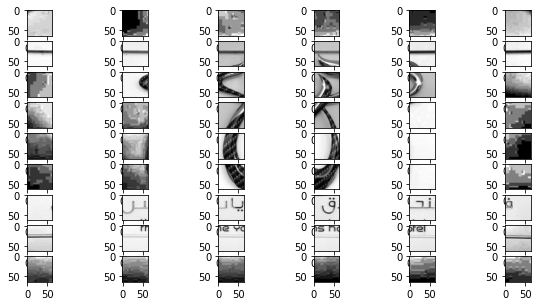

In [ ]:
img_patches = tf.convert_to_tensor([[img[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blocks)] for i in range(h_blocks)])
print(img_patches.shape)
plt.figure(figsize = (10,5))
for i in range(h_blocks*w_blocks):
  plt.subplot(h_blocks, w_blocks, i+1)
  plt.imshow(img_patches[i//w_blocks][i%w_blocks][...,0], cmap='gray')

In [ ]:
output = model_combined([img_patches/255], training=False)  # the demo is in range [0,255], needs to divide by 255 before 
                                                            # feed into the model
output.shape

TensorShape([1, 256, 1])

In [ ]:
output = output[0,:,0].numpy().reshape(16, 16)
output = tf.convert_to_tensor(output, dtype=tf.float32)
output

<tf.Tensor: shape=(16, 16), dtype=float32, numpy=
array([[-7.9716506 , -8.097841  , -7.9493494 , -8.126218  , -8.468433  ,
        -8.060169  , -3.595179  , -4.1130075 , -3.2274282 , -3.9878638 ,
        -4.0573196 , -4.116075  , -4.055831  , -4.276828  , -4.268801  ,
        -4.6352787 ],
       [-6.639061  , -5.024096  , -5.111775  , -4.331134  , -4.029096  ,
        -5.112097  , -4.2611494 , -4.2683496 , -3.732704  , -3.9481163 ,
        -4.047379  , -3.9552073 , -3.8338842 , -4.191247  , -4.202552  ,
        -4.3314333 ],
       [-6.2869496 , -2.500317  ,  0.15904698,  0.23653296,  0.23600617,
        -5.219083  , -2.4979153 , -4.371456  , -3.4093273 , -3.7824748 ,
        -4.0495405 , -3.9801967 , -3.8525476 , -4.2691164 , -4.2843904 ,
        -4.2958355 ],
       [-7.546871  , -6.6818695 , -4.102707  , -1.4749558 , -5.3816032 ,
        -6.752533  , -1.941907  , -3.423632  , -3.0195942 , -3.2400396 ,
        -3.85236   , -3.8373094 , -3.7808642 , -4.223824  , -4.352073  ,
        

In [ ]:
# we can see that generally the values corresponding to the actual labels have positive value
# [[6, 1], [6, 4], [7, 2], [7, 3], [7, 4]]
y = output[6:8,:]
y

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[-4.1741323 ,  0.4270363 ,  2.2879264 ,  2.2004616 ,  0.85328275,
        -1.6577922 , -2.5085995 , -4.3836675 , -3.4589734 , -3.366782  ,
        -3.816501  , -3.7814147 , -3.7808642 , -4.223824  , -4.352073  ,
        -4.3283286 ],
       [-4.3973193 , -0.64467394,  3.95097   ,  4.1244435 ,  2.8525848 ,
        -5.309778  , -2.2520032 , -3.4463313 , -3.3886685 , -3.5322    ,
        -3.8068304 , -3.769623  , -3.7808642 , -4.223824  , -4.352073  ,
        -4.3283286 ]], dtype=float32)>

In [ ]:
# [[6, 1], [6, 4], [7, 2], [7, 3], [7, 4]]
y > 0

<tf.Tensor: shape=(2, 16), dtype=bool, numpy=
array([[False,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False]])>

In [ ]:
# batched prediction of 1,000 validation images
val_outputs = []
val_batch = 25
for i in range(len(val_array)//val_batch): # 1000//25 = 40 
  print(i)
  batch_val = []
  for j in range(val_batch):
    idx = val_batch*i+j
    img_idx = val_array[idx]
    img_np = np.load(f'{save_path}/img_npys/img_{img_idx+1}.npy')  # img start from 1 here
    img_tensor = tf.convert_to_tensor(img_np)
    h_blk, w_blk = img_tensor.shape[1]//64, img_tensor.shape[2]//64
    patches = tf.convert_to_tensor([[img_tensor[0,i*64:(i+1)*64,j*64:(j+1)*64,:] for j in range(w_blk)] 
                                    for i in range(h_blk)])
    batch_val.append(patches)

  outputs = model_combined(batch_val, training=False)
  assert(outputs.shape == (val_batch, 256, 1))

  for j in range(val_batch):
    output_slice = outputs[j,:,0].numpy().reshape(16, 16)
    val_outputs.append(output_slice)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
# import pickle
# with open(f"{parent_path}/npy_files/val_outputs_v2_blk", "wb") as fp:   # Pickling
#   pickle.dump(val_outputs, fp)

In [ ]:
with open(f"{parent_path}/npy_files/val_outputs_v2_blk", "rb") as fp:   # Unpickling
  val_outputs = pickle.load(fp)
len(val_outputs), val_outputs[0].shape

(1000, (16, 16))

Compute F1-score on validation images. Note that we can change the threshold to determine if we are more strict or relaxed on having positive outputs. Due to the tensorflow loss function setup, the threshold here is the value before sigmoid activation (so a threshold of 0. actually means a probability of 0.5). Since we are evaluating on validation sets, we are free to change the threshold to find the best value as long as we keep it fixed during actual testing.

In [ ]:
TP, FP, FN = [0, 0, 0]
threshold = 1.
for idx in range(len(val_array)):
  val_map = val_outputs[idx]
  val_idx = val_array[idx]
  h_blk, w_blk = num_blocks[val_idx, 0], num_blocks[val_idx, 1]
  lb = label_list[val_idx]
  label_map = np.zeros((16, 16))
  for k in range(len(lb)):
    label_map[lb[k][0], lb[k][1]] = 1
  for i in range(h_blk):
    for j in range(w_blk):
      if label_map[i][j] == 1 and val_map[i][j] > threshold:
        TP += 1
      elif label_map[i][j] == 1 and val_map[i][j] <= threshold:
        FN += 1
      elif label_map[i][j] == 0 and val_map[i][j] > threshold:
        FP += 1

print(TP, FP, FN, TP+FN)
precision, recall = TP/(TP+FP), TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)
print(precision, recall, f1_score)

3509 3824 3154 6663
0.4785217509886813 0.5266396518084947 0.5014289797084881


In [ ]:
# transformer version
# TP=3261, FP=4099, FN=3402, total_tags=6663; 

# threshold = 1. (before sigmoid):
# precision=0.3923, recall=0.5669, f1_score=0.4637;

# threshold = 1.39 (before sigmoid): [highest one here]
# precision=0.4665, recall=0.4818, f1_score=0.4740;

# threshold = 1.5 (before sigmoid):
# precision=0.4889, recall=0.4570, f1_score=0.4724;

# threshold = 1.75 (before sigmoid):
# precision=0.5341, recall=0.4025, f1_score=0.4591;

In [ ]:
# inception block version
# TP=3509, FP=3824, FN=3154, total_tags=6663; 

# threshold = 0.5 (before sigmoid):
# precision=0.4054, recall=0.6252, f1_score=0.4919;

# threshold = 1. (before sigmoid): [highest one here]
# precision=0.4785, recall=0.5266, f1_score=0.5014;

# threshold = 1.39 (before sigmoid):
# precision=0.5372, recall=0.4430, f1_score=0.4856;

# threshold = 1.5 (before sigmoid):
# precision=0.5514, recall=0.4162, f1_score=0.4743;

In [ ]:
# the mapping from threshold before sigmoid to the corresponding probability after sigmoid
tf.sigmoid([0.5, 1., 1.39, 1.5, 1.75])

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.62245935, 0.73105854, 0.80059224, 0.81757444, 0.85195285],
      dtype=float32)>